In [23]:
import numpy as np
import pandas as pd

In [24]:
# Input the data
data = pd.read_csv('Shamoun-Baranes et al. (2016).csv');

b=data.shape;   #shape
# print(b)

In [25]:
# filter out one animols
animal_ID_317 = data[data['BirdID']==317]
# animal_ID_317

In [26]:
import time
import datetime
# timestamp
animal_ID_317.DateTime = pd.to_datetime(animal_ID_317.DateTime)
animal_ID_317.head()

C:\Users\Studying\AppData\Local\Temp\ipykernel_17324\3625234355.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animal_ID_317.DateTime = pd.to_datetime(animal_ID_317.DateTime)


,BirdID,BirdYear,Destination,DateTime,Longitude,Latitude,CumulativeDistance,ColonyDistance
19918,317,317 (2010),IberianPeninsula,2010-06-01 00:48:00,4.132943,52.899424,0.991786,22.835252
19919,317,317 (2010),IberianPeninsula,2010-06-01 01:11:00,4.127699,52.893184,1.897008,23.486885
19920,317,317 (2010),IberianPeninsula,2010-06-01 01:35:00,4.122706,52.886938,2.784944,24.132009
19921,317,317 (2010),IberianPeninsula,2010-06-01 01:58:00,4.115767,52.880747,3.818170,24.891514
19922,317,317 (2010),IberianPeninsula,2010-06-01 02:21:00,4.101258,52.874910,5.556956,26.061659


In [27]:
# set index (datetime)
animal_ID_317 = animal_ID_317.set_index('DateTime')
animal_ID_317.head()

# sort the index
animal_ID_317.sort_index(ascending = True).head()

,BirdID,BirdYear,Destination,Longitude,Latitude,CumulativeDistance,ColonyDistance
DateTime,,,,,,,
2010-06-01 00:48:00,317,317 (2010),IberianPeninsula,4.132943,52.899424,0.991786,22.835252
2010-06-01 01:11:00,317,317 (2010),IberianPeninsula,4.127699,52.893184,1.897008,23.486885
2010-06-01 01:35:00,317,317 (2010),IberianPeninsula,4.122706,52.886938,2.784944,24.132009
2010-06-01 01:58:00,317,317 (2010),IberianPeninsula,4.115767,52.880747,3.818170,24.891514
2010-06-01 02:21:00,317,317 (2010),IberianPeninsula,4.101258,52.874910,5.556956,26.061659


In [28]:
# the location of animal
animal_ID_317_pre_data = animal_ID_317[animal_ID_317.columns[3:5]]
# animal_ID_317_pre_data()

a = animal_ID_317_pre_data.resample('D').mean()
animal_ID_317_data = a.resample('D').interpolate('linear')

animal_ID_317_data

,Longitude,Latitude
DateTime,,
2010-06-01,4.583350,52.966381
2010-06-02,4.717499,53.010517
2010-06-03,4.697161,53.010346
2010-06-04,4.532929,52.930248
2010-06-05,4.697379,53.008980
...,...,...
2015-05-27,4.830571,52.864545
2015-05-28,4.777756,52.935721
2015-05-29,4.873837,52.813498


In [30]:
def Best_model(animal_ID_317_data,memory_days,pre_days):

    animal_ID_317_data['label_1'] = animal_ID_317_data['Longitude'].shift(-pre_days)
    animal_ID_317_data['label_2'] = animal_ID_317_data['Latitude'].shift(-pre_days)
    # animal_ID_317_data

    # Standardlise
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler()
    data_scalar = scalar.fit_transform(animal_ID_317_data.iloc[:,:-2])
    # print(data_scalar)

    from collections import deque
    deq = deque(maxlen=memory_days)

    # processing queue--input features
    queue_input = []
    for i in data_scalar:
        deq.append(list(i))
        if len(deq)==memory_days:
            queue_input.append(list(deq))
    print(len(queue_input))      # 4 data missed 825399-825395

    # processing the final misssing data ( cut the pre_days data )
    queue_last = queue_input[-pre_days:]
    queue_input = queue_input[:-pre_days]

    queue_output = animal_ID_317_data.iloc[:,2:4].values[memory_days-1:-pre_days]

    # transfer list to array
    queue_input = np.array(queue_input)

    queue_output = np.array(queue_output)
    return queue_input,queue_output,queue_last

In [46]:
pre_days =50
memory_days=[10]
lstm_layers=[2]
dense_layers=[1]
units = [32]

from keras.callbacks import ModelCheckpoint

for the_memory_days in memory_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_lstm_layers}_lstm{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                Checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=True,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)

                queue_input,queue_output,queue_last = Best_model(animal_ID_317_data,the_memory_days,pre_days)

                # split into traning and test datasets
                from sklearn.model_selection import train_test_split
                queue_input_train,queue_input_test,queue_output_train,queue_output_test = train_test_split(queue_input,queue_output,shuffle=False,test_size=0.1)
                
                
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM,Dense,Dropout

                # Build model
                model = Sequential()
                model.add(LSTM(the_units,input_shape = queue_input.shape[1:],activation='relu',return_sequences=True)) # first layer
                model.add(Dropout(0.1))   # prevent overfitting
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True)) # second layer
                    model.add(Dropout(0.1))   # prevent overfitting

                model.add(LSTM(the_units,activation='relu')) # third layer
                model.add(Dropout(0.1))   # prevent overfitting

                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu')) # # fully connected layer
                    model.add(Dropout(0.1))   # prevent overfitting

                model.add(Dense(2)) #  output layer

                # compile model
                model.compile(optimizer='adam',
                              loss='mse',
                              metrics=['mape'])      
                
                # model traning
                model.fit(queue_input_train,queue_output_train,batch_size=32,epochs=50,validation_data=(queue_input_test,queue_output_test),callbacks=[Checkpoint])

1817
Epoch 1/50
50/50 [==============================] - 4s 21ms/step - loss: 839.0142 - mape: 91.9595 - val_loss: 591.8922 - val_mape: 86.7899
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 103.0316 - mape: 69.7509 - val_loss: 32.1164 - val_mape: 59.1419
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 52.1817 - mape: 63.4130 - val_loss: 30.0846 - val_mape: 57.4387
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 47.5613 - mape: 67.0788 - val_loss: 30.8908 - val_mape: 56.5854
Epoch 5/50
50/50 [==============================] - 1s 14ms/step - loss: 44.4476 - mape: 57.2195 - val_loss: 29.3780 - val_mape: 55.9906
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 38.7570 - mape: 58.6304 - val_loss: 28.0299 - val_mape: 56.2635
Epoch 7/50
50/50 [==============================] - 1s 14ms/step - loss: 41.7318 - mape: 58.0485 - val_loss: 30.3645 - val_mape: 56.4002
Epoch 8/50
50/50 [===============

In [47]:
pre = model.predict(queue_input_test)
print(pre)

6/6 [==============================] - 0s 5ms/step
[[-2.4402213  40.934814  ]
 [-2.429983   41.009247  ]
 [-2.4393861  40.957714  ]
 [-2.445745   40.885742  ]
 [-2.4428527  40.854496  ]
 [-2.4174767  40.98914   ]
 [-2.3938096  41.142216  ]
 [-2.375728   41.270214  ]
 [-2.364446   41.36635   ]
 [-2.3624158  41.410786  ]
 [-2.3698883  41.391342  ]
 [-2.3873117  41.286777  ]
 [-2.4033854  41.17514   ]
 [-2.414062   41.09381   ]
 [-2.4227495  41.07099   ]
 [-2.4422982  41.01449   ]
 [-2.4792633  40.88159   ]
 [-2.5365856  40.633465  ]
 [-2.6106753  40.23469   ]
 [-2.6858294  39.70283   ]
 [-2.7429388  39.08148   ]
 [-2.7126417  39.06483   ]
 [-2.5978737  39.666985  ]
 [-2.470782   40.26821   ]
 [-2.3359692  40.85067   ]
 [-2.1938338  41.424355  ]
 [-2.0465472  42.001175  ]
 [-1.8997867  42.570473  ]
 [-1.7674845  43.060818  ]
 [-1.6932646  43.28592   ]
 [-1.6771059  43.224495  ]
 [-1.5645999  43.428036  ]
 [-1.2901655  44.112946  ]
 [-0.8594669  45.140312  ]
 [-0.60024446 45.636642  ]
 [-0

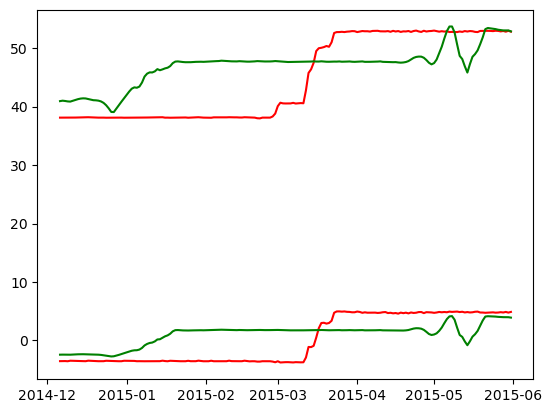

In [48]:
import matplotlib.pyplot as plt
data_time = animal_ID_317_data.index[-len(queue_output_test):]
plt.plot(data_time,queue_output_test,color='red')
plt.plot(data_time,pre,color='green')
plt.show()

In [49]:
print(len(queue_output_test))
print(len(queue_input_test))
print(len(pre))
print(queue_output_test.shape)
print(queue_input_test.shape)

177
177
177
(177, 2)
(177, 10, 2)


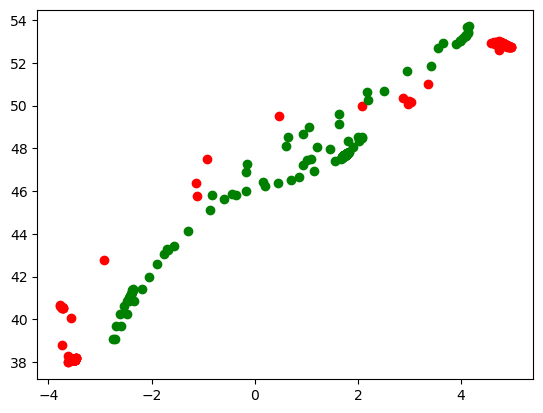

In [50]:
plt.scatter(queue_output_test[:,0],queue_output_test[:,1],color='red')
plt.scatter(pre[:,0],pre[:,1],color='green')
# plt.plot(data_time,pre,color='green')
plt.show()